# **Reflected Light Phase Curves**

**Citation: Hamill et al. (2024) : Reflected Light Phase Curves with PICASO: A Kepler-7b Case Study**

Computing a reflected light phase curve is similar to computing 3D reflected light spectra, but now we will compute reflected spectra for an entire grid of phase angles.

From the previous tutorials you should understand:

1. How to convert GCM input to PICASO's required Xarray
2. How to post-process output to append to GCM ouput
3. How to run a thermal phase curve and analyze the output

In this tutorial, you will learn:

1. How to compute a reflected light phase curve
2. How to analyze the output

In [1]:
import pandas as pd
import numpy as np

from astropy import units as u

import xarray as xr

from picaso import justdoit as jdi
from picaso import justplotit as jpi
jpi.output_notebook()

Loading BokehJS ...

## Setting Up Reflected Light Phase Curve

Reflected light calculations consider only scattering from the dayside hemisphere. The dayside hemisphere will continually come in or out of view depending on the phase angle.

Let's load in opacity for the visible to near-infrared and the 3D hot Jupiter atmosperic model:

We are resampling our opacities here to make phase curve calculations faster! Use resampling with caution in your own phase curve calculations!!

In [2]:
opacity = jdi.opannection(wave_range=[0.50,0.90], resample=100)  # this is the wavelength band of Kepler

YOU ARE REQUESTING RESAMPLING!! This could degrade the precision of your spectral calculations so should be used with caution. If you are unsure check out this tutorial: https://natashabatalha.github.io/picaso/notebooks/10_ResamplingOpacities.html


In [3]:
gcm_out =  jdi.HJ_pt_3d(as_xarray=True)

### Add chemistry. 

We can use user-input chemistry for this example.

To use post-processed chemical abundances, use the same methods in [Modeling a Phase Curve pt 2 (Robbins-Blanch et al. 2022) : Run Thermal Phase Curve w/ Post-Processed Chemical Abundances.](https://natashabatalha.github.io/picaso/notebooks/9f_PhaseCurves-wChemEq.html)


In [4]:
# create coords
lon = gcm_out.coords.get('lon').values
lat = gcm_out.coords.get('lat').values
pres = gcm_out.coords.get('pressure').values

fake_chem_H2O = np.random.rand(len(lon), len(lat),len(pres))*0.1+0.1 # create fake data
fake_chem_H2 = 1-fake_chem_H2O # create data

# put data into a dataset
ds_chem = jdi.xr.Dataset(
    data_vars=dict(
        H2O=(["lon", "lat","pressure"], fake_chem_H2O,{'units': 'v/v'}),
        H2=(["lon", "lat","pressure"], fake_chem_H2,{'units': 'v/v'}),

    ),
    coords=dict(
        lon=(["lon"], lon,{'units': 'degrees'}), #required
        lat=(["lat"], lat,{'units': 'degrees'}), #required
        pressure=(["pressure"], pres,{'units': 'bar'})#required*
    ),
    attrs=dict(description="coords with vectors"),
)
all_gcm = gcm_out.update(ds_chem)

all_gcm

<xarray.Dataset> Size: 10MB
Dimensions:      (lon: 128, lat: 64, pressure: 53)
Coordinates:
  * lon          (lon) float64 1kB -180.0 -177.2 -174.4 ... 171.6 174.4 177.2
  * lat          (lat) float64 512B -90.0 -87.19 -84.38 ... 81.56 84.38 87.19
  * pressure     (pressure) float64 424B 170.6 120.5 ... 3.42e-06 2.416e-06
Data variables:
    temperature  (lon, lat, pressure) float64 3MB 1.896e+03 1.809e+03 ... 750.7
    H2O          (lon, lat, pressure) float64 3MB 0.1849 0.15 ... 0.1658 0.1611
    H2           (lon, lat, pressure) float64 3MB 0.8151 0.85 ... 0.8342 0.8389
Attributes:
    description:  coords with vectors

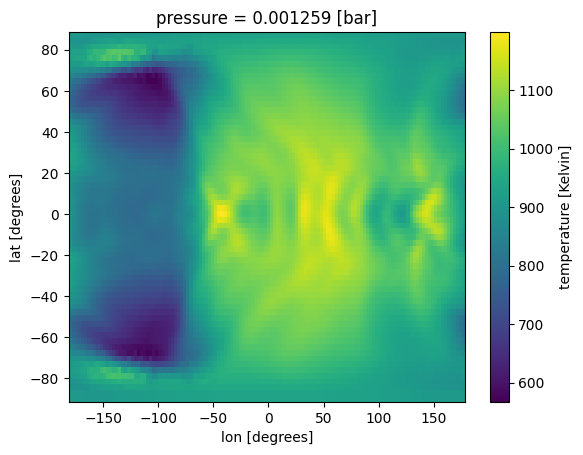

In [5]:
all_gcm['temperature'].isel(pressure=34).plot(x='lon',y='lat')

### Set up phase curve grid 

Define the number of phases, and the minimum and maximum phase.

For reflected phase curves, the minimum spatial resolution accepted by PICASO is 6 x 6 (num_gangle=6, num_tangle=6).

In [6]:
case_3d = jdi.inputs()

n_phases = 8
min_phase = 0
max_phase = 2*np.pi
phase_grid = np.linspace(min_phase,max_phase,n_phases)#between 0 - 2pi
#send params to phase angle routine
#case_3d.phase_angle(phase_grid=phase_grid,
#                    num_gangle=6, num_tangle=6,calculation='reflected')
case_3d.phase_curve_geometry('reflected', phase_grid=phase_grid, num_gangle=6, num_tangle=6)

A few notes: 

- Phase = 0 is the secondary eclipse (maximum reflection)
- Phase = 2*pi (~6.28) is the primary eclipse (no reflection).

Things to check: 
- Ensure that (0 degrees longitude, 0 degrees latitude) represents your substellar point on the planet. If it does not, you will need to change your reference point in your GCM.
- For the reflected case, zero_point must be set to 'secondary eclipse'.
- For a tidally locked planet, set shift to 0 at all phase angles.

/home/nbatalh1/anaconda3/envs/pic311/lib/python3.11/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


/home/nbatalh1/anaconda3/envs/pic311/lib/python3.11/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


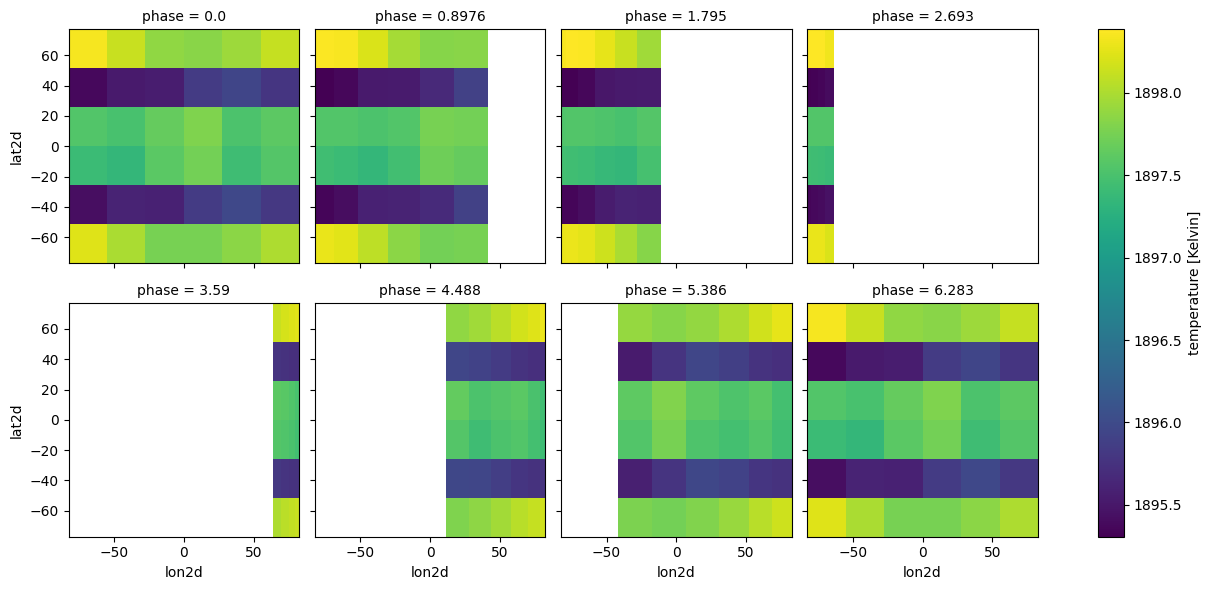

In [7]:
case_3d.atmosphere_4d(all_gcm, shift = np.zeros(n_phases), zero_point='secondary_eclipse',
                                     plot=True,verbose=False)

### `Atmosphere_4d`

Atmosphere_4d function works by adding 'phase' as another coordinate in the GCM. 'lat2d' and 'lon2d' are also created and store the specific lats/lons for which the dayside hemisphere is visible to the observer at each individual phase.

In [8]:
case_3d.inputs['atmosphere']['profile']

<xarray.Dataset> Size: 368kB
Dimensions:       (phase: 8, pressure: 53, lat: 6, lon: 6)
Coordinates:
  * pressure      (pressure) float64 424B 170.6 120.5 ... 3.42e-06 2.416e-06
  * lon           (lon) float64 48B -68.82 -41.39 -13.81 13.81 41.39 68.82
  * lat           (lat) float64 48B 64.29 38.57 12.86 -12.86 -38.57 -64.29
  * phase         (phase) float64 64B 0.0 0.8976 1.795 ... 4.488 5.386 6.283
    lon2d         (phase, lon) float64 384B -68.82 -41.39 ... -41.39 -68.82
    lat2d         (phase, lat) float64 384B 64.29 38.57 12.86 ... -38.57 -64.29
    lon2d_clouds  (phase, lon) float64 384B -68.82 -41.39 ... -41.39 -68.82
    lat2d_clouds  (phase, lat) float64 384B 64.29 38.57 12.86 ... -38.57 -64.29
Data variables:
    temperature   (phase, pressure, lat, lon) float64 122kB 1.898e+03 ... 798.1
    H2O           (phase, pressure, lat, lon) float64 122kB 0.1503 ... 0.1607
    H2            (phase, pressure, lat, lon) float64 122kB 0.8497 ... 0.8393
Attributes:
    description:    coords with vectors
    regrid_method:  bilinear

## Compute the reflected light phase curve.

Note: Planetary radius, orbital distance, and stellar radius is needed to compute reflected phase curves in units of planet/star flux ratio (Fp/Fs).

In [9]:
case_3d.gravity(radius=1,radius_unit=jdi.u.Unit('R_jup'),
                mass=1, mass_unit=jdi.u.Unit('M_jup')) #any astropy units available
case_3d.star(opacity,5000,0,4.0, radius=1, radius_unit=jdi.u.Unit('R_sun'), semi_major=0.06, semi_major_unit=u.Unit('au'))

Phase curve computation is below. Computation time will vary widely depending on number of phases and spatial resolution used. We recommend a high performance computer for any phase curves greater than 10x10 spatial resolution. Please see the Appendix of Hamill et al. (2024) for example computation times.

In [10]:
case_3d.inputs['atmosphere']['profile'].isel(phase=1)

<xarray.Dataset> Size: 47kB
Dimensions:       (pressure: 53, lat: 6, lon: 6)
Coordinates:
  * pressure      (pressure) float64 424B 170.6 120.5 ... 3.42e-06 2.416e-06
  * lon           (lon) float64 48B -68.82 -41.39 -13.81 13.81 41.39 68.82
  * lat           (lat) float64 48B 64.29 38.57 12.86 -12.86 -38.57 -64.29
    phase         float64 8B 0.8976
    lon2d         (lon) float64 48B -76.05 -61.78 -41.7 -18.93 5.08 29.55
    lat2d         (lat) float64 48B 64.29 38.57 12.86 -12.86 -38.57 -64.29
    lon2d_clouds  (lon) float64 48B -34.66 -20.39 -0.3119 22.45 46.47 70.94
    lat2d_clouds  (lat) float64 48B 64.29 38.57 12.86 -12.86 -38.57 -64.29
Data variables:
    temperature   (pressure, lat, lon) float64 15kB 1.898e+03 ... 871.9
    H2O           (pressure, lat, lon) float64 15kB 0.1701 0.1448 ... 0.1484
    H2            (pressure, lat, lon) float64 15kB 0.8299 0.8552 ... 0.8516
Attributes:
    description:    coords with vectors
    regrid_method:  bilinear

In [11]:
allout = case_3d.phase_curve(opacity, n_cpu = 3,#jdi.cpu_count(),
                             full_output=True)

## Plot the phase curve!

In [12]:
to_plot = 'fpfs_reflected' 
#collapse = [0.40 ]#micron, could select one or more specific wavelengths instead of the mean 
collapse='np.mean'

phases, all_curves, all_ws, fig=jpi.phase_curve(allout, to_plot,
                                                collapse=collapse, R=10,reorder_output=True)

jpi.show(fig)

### Phase-resolved spectra used to create the phase curve.


Since chemistry is randomized for this tutorial and there are no clouds, the spectra is mostly symmetrical across 0 degrees phase angle.

In [13]:
#same old same old
wno =[];fpfs=[];legend=[]
for iphase in allout.keys():
    w,f = jdi.mean_regrid(allout[iphase]['wavenumber'],
                               allout[iphase]['fpfs_reflected'], R=100)
    wno+=[w]
    fpfs+=[f*1e6]
    legend +=[str(int(iphase*180/np.pi))]
jpi.show(jpi.spectrum(wno, fpfs, plot_width=500,legend=legend,
                     palette=jpi.pals.viridis(n_phases)))

## Reflected phase curve with `Virga` clouds 

In reflected light brightness can be heavily influenced by cloud layers. Let's add a user-input cloud layer and compare ouputs**

To use Virga clouds, please use the same steps found in [Modeling a 3D spectrum (Adams et al. 2022) : Run Cloudy 3D spectra](https://natashabatalha.github.io/picaso/notebooks/9c_PostProcess3Dinput-Clouds.html#Post-Process-Clouds:-virga-cloud-model) or [Modeling a Phase Curve pt 2 : Run Thermal Phase Curves w/ Post-Processed Virga Models](https://natashabatalha.github.io/picaso/notebooks/9f_PhaseCurves-wChemEq.html#Run-Thermal-Phase-Curve-w/-Post-Processed-virga-Models)

If you use Virga clouds for reflected phase curves, we highly advise against regridding beforehand. This means your Virga clouds may take a while to compute, but it prevents issues with the re-mapping used in `clouds_4d`.

In [14]:
# create coords
lon = gcm_out.coords.get('lon').values
lat = gcm_out.coords.get('lat').values
pres = gcm_out.coords.get('pressure').values[:-1]
wno_grid = np.linspace(33333,1e4,10) #cloud properties are defined on a wavenumber grid

#create box-band cloud model
fake_opd = np.zeros((len(lon), len(lat),len(pres), len(wno_grid))) # create fake data
where_lat = np.where(((lat>-50) & (lat<50)))#creating a grey cloud band
where_lon = np.where(((lon>-90) & (lon<0)))#creating a grey cloud band
where_pres = np.where(((pres<0.01) & (pres>.00001)))#creating a grey cloud band, 10 mbar to 0.01 mbar
for il in where_lat[0]:
    for ilon in where_lon[0]:
        for ip in where_pres[0]:
            fake_opd[ilon,il,ip,:]=10 #optical depth of 10 (>>1)

#make up asymmetry and single scattering properties
fake_asymmetry_g0 = 0.5 + np.zeros((len(lon), len(lat),len(pres), len(wno_grid)))
fake_ssa_w0 = 0.9 + np.zeros((len(lon), len(lat),len(pres), len(wno_grid)))

# put data into a dataset
ds_cld= xr.Dataset(
    data_vars=dict(
        opd=(["lon", "lat","pressure","wno"], fake_opd,{'units': 'depth per layer'}),
        g0=(["lon", "lat","pressure","wno"], fake_asymmetry_g0,{'units': 'none'}),
        w0=(["lon", "lat","pressure","wno"], fake_ssa_w0,{'units': 'none'}),
    ),
    coords=dict(
        lon=(["lon"], lon,{'units': 'degrees'}),#required
        lat=(["lat"], lat,{'units': 'degrees'}),#required
        pressure=(["pressure"], pres,{'units': 'bar'}),#required
        wno=(["wno"], wno_grid,{'units': 'cm^(-1)'})#required for clouds
    ),
    attrs=dict(description="coords with vectors"),
)

ds_cld

<xarray.Dataset> Size: 102MB
Dimensions:   (lon: 128, lat: 64, pressure: 52, wno: 10)
Coordinates:
  * lon       (lon) float64 1kB -180.0 -177.2 -174.4 ... 171.6 174.4 177.2
  * lat       (lat) float64 512B -90.0 -87.19 -84.38 ... 81.56 84.38 87.19
  * pressure  (pressure) float64 416B 170.6 120.5 85.15 ... 4.841e-06 3.42e-06
  * wno       (wno) float64 80B 3.333e+04 3.074e+04 ... 1.259e+04 1e+04
Data variables:
    opd       (lon, lat, pressure, wno) float64 34MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    g0        (lon, lat, pressure, wno) float64 34MB 0.5 0.5 0.5 ... 0.5 0.5 0.5
    w0        (lon, lat, pressure, wno) float64 34MB 0.9 0.9 0.9 ... 0.9 0.9 0.9
Attributes:
    description:  coords with vectors

### Sanity Check 

Plot of our optically thick cloud layer that lies on the western dayside. 

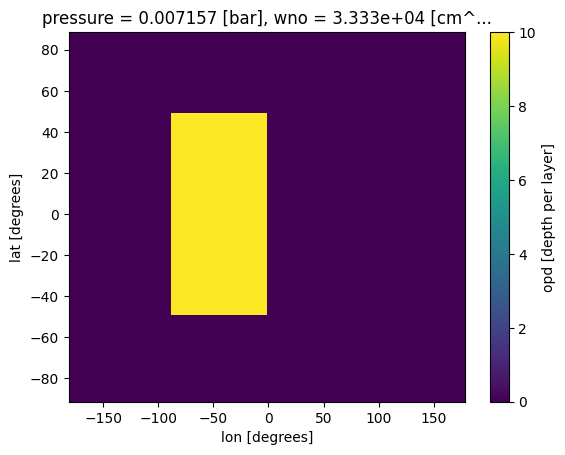

In [15]:
ds_cld['opd'].isel(pressure=where_pres[0][0],wno=0).plot(x='lon',y='lat')

### Run clouds_4d 

Set up phase curve calculation same as before. The only difference is we are now running clouds_4d as well.

/home/nbatalh1/anaconda3/envs/pic311/lib/python3.11/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


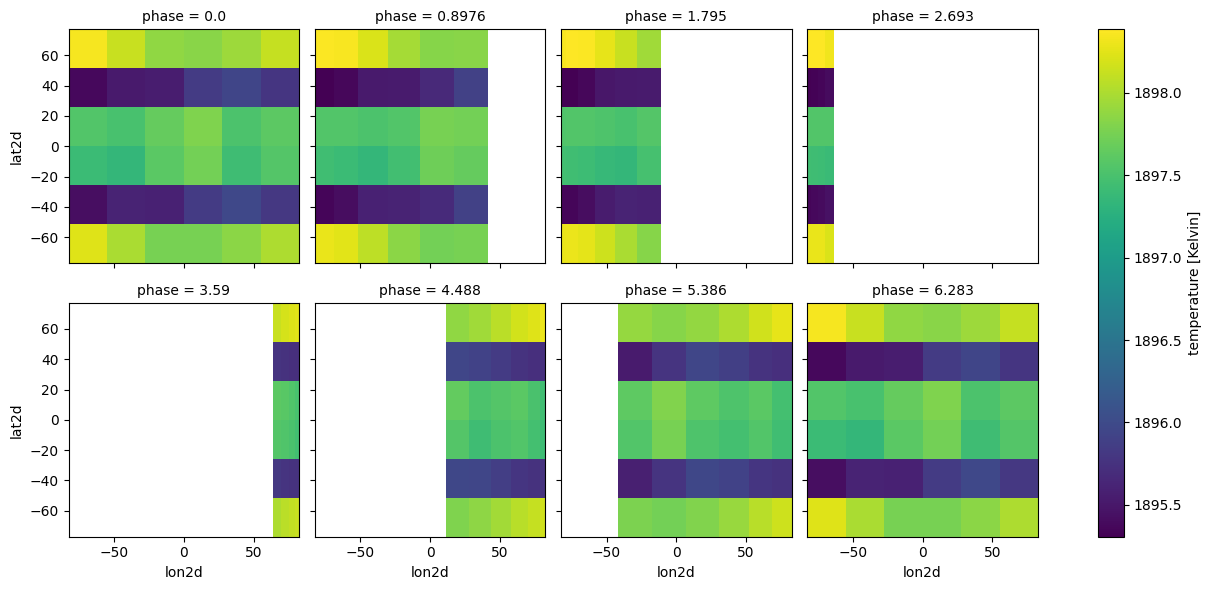

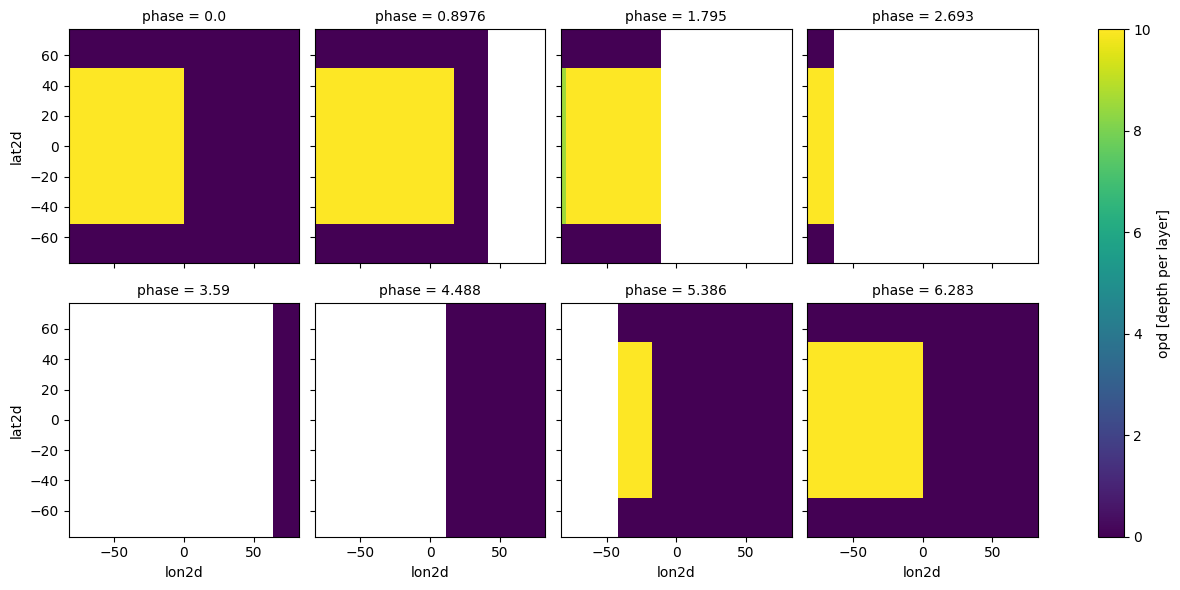

In [16]:
case_3d_clouds = jdi.inputs()

n_phases = 8
min_phase = 0
max_phase = 2*np.pi
phase_grid = np.linspace(min_phase,max_phase,n_phases)#between 0 - 2pi
#send params to phase angle routine
#case_3d.phase_angle(phase_grid=phase_grid,
#                    num_gangle=6, num_tangle=6,calculation='reflected')

case_3d_clouds.phase_curve_geometry('reflected', phase_grid=phase_grid, num_gangle=6, num_tangle=6)
case_3d_clouds.inputs['atmosphere']['profile']

case_3d_clouds.atmosphere_4d(gcm_out, shift = np.zeros(n_phases), zero_point='secondary_eclipse',
                                     plot=True,verbose=False)

# run clouds_4d (which must always run after atmosphere_4d)
case_3d_clouds.clouds_4d(ds_cld, iz_plot=34, plot=True)

## **Calculate cloudy phase curve**

In [17]:
case_3d_clouds.gravity(radius=1,radius_unit=jdi.u.Unit('R_jup'),
                mass=1, mass_unit=jdi.u.Unit('M_jup')) #any astropy units available
case_3d_clouds.star(opacity,5000,0,4.0, radius=1, radius_unit=jdi.u.Unit('R_sun'), semi_major=0.06, semi_major_unit=u.Unit('au'))

allout_clouds = case_3d_clouds.phase_curve(opacity, n_cpu = 3,#jdi.cpu_count(),
                             full_output=False)

In [18]:
to_plot = 'fpfs_reflected' #or thermal
#collapse = [0.40 ]#micron
collapse='np.mean'
#phases, all_curves, all_ws, fig=jpi.phase_curve(allout, to_plot, collapse=collapse, R=R)
phases, all_curves, all_ws, fig=jpi.phase_curve(allout, to_plot, collapse=collapse, R=10,plot_width=1500, reorder_output=True)
phases_clouds, all_curves_clouds, all_ws_clouds, fig_clouds=jpi.phase_curve(allout_clouds, to_plot, collapse=collapse, R=10,plot_width=1500, reorder_output=True)
#jpi.show(fig)

### Compare cloudy and cloud free

Below is a comparison between our cloudless and cloudy phase curves. The cloudy phase curve is much brighter. We also see a shift in the phase maximum due to our inhomogeneous cloud layer.

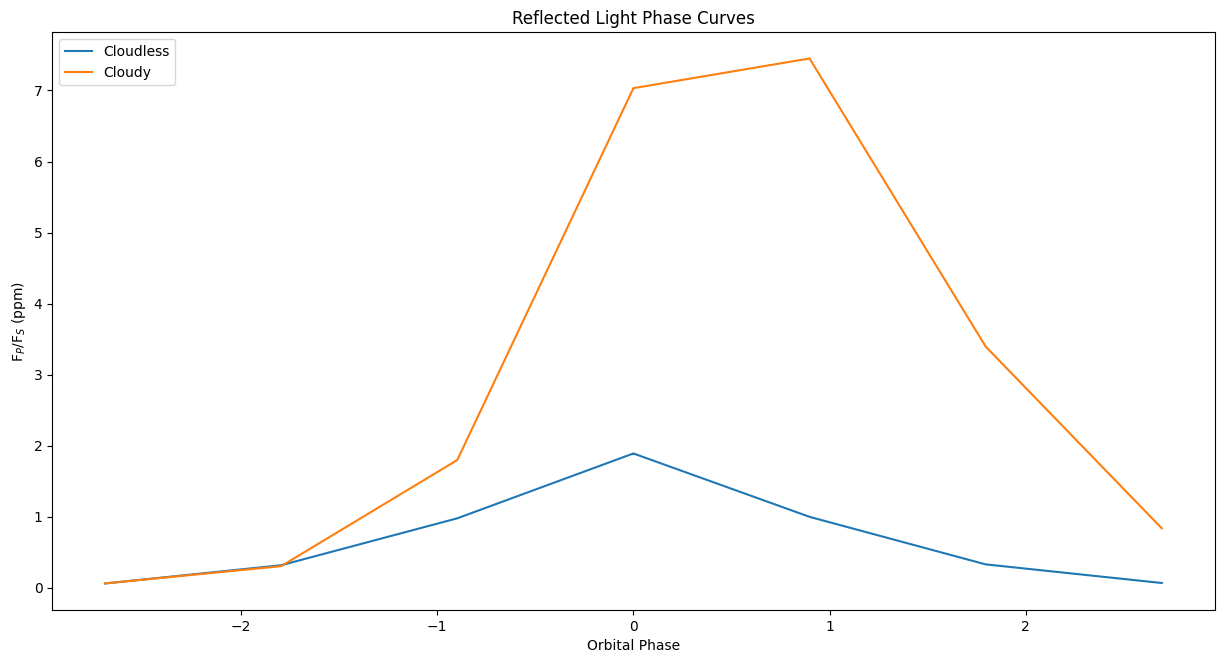

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7.5))

plt.plot(phases,all_curves * 1e6, label="Cloudless")
plt.plot(phases_clouds,all_curves_clouds * 1e6, label="Cloudy")

plt.xlabel('Orbital Phase')
plt.ylabel('F$_{P}$/F$_{S}$ (ppm)')
plt.title('Reflected Light Phase Curves')
plt.legend(loc='upper left')
plt.rcParams['font.size'] = 15



### Cloudy phase spectra

The spectra for phase angles < 180 is flat due to clouds.

In [20]:
#same old same old
wno =[];fpfs=[];legend=[]
for iphase in allout_clouds.keys():
    w,f = jdi.mean_regrid(allout_clouds[iphase]['wavenumber'],
                               allout_clouds[iphase]['fpfs_reflected'], R=100)
    wno+=[w]
    fpfs+=[f*1e6]
    legend +=[str(int(iphase*180/np.pi))]
jpi.show(jpi.spectrum(wno, fpfs, plot_width=500,legend=legend,
                     palette=jpi.pals.viridis(n_phases)))

To further analyze your output, you can use all of the same tools found in [Modeling a Phase Curve pt 1 (Robbins-Blanch et al. 2022) > Phase Curve Plotting Tools: Phase Snaps](https://natashabatalha.github.io/picaso/notebooks/9e_PhaseCurves.html#Phase-Curve-Plotting-Tools:-Phase-Snaps)